In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os
import copy
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,),(0.3081,))        
    ])),
    batch_size = 64,
    shuffle=True 
)

valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=False, download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,),(0.3081,))        
    ])),
    batch_size = 128,
    shuffle=True
)



In [16]:
class Teacher(nn.Module): 
  def __init__(self): 
    super().__init__()
    self.fc1 = nn.Linear(28*28, 1200)
    self.bn1 = nn.BatchNorm1d(1200)
    self.fc2 = nn.Linear(1200,1200)
    self.bn2 = nn.BatchNorm1d(1200)
    self.fc3 = nn.Linear(1200, 10)
    
  def forward(self,x):
    x = x.view(-1, 28*28)
    x = F.relu(self.bn1(self.fc1(x)))
    x = F.dropout(x,p=0.8)
    x = F.relu(self.bn2(self.fc2(x)))
    x = F.dropout(x,p=0.8)
    x = self.fc3(x)
    return x

In [19]:
x = torch.randn(16,1,28,28).to(device)
teacher = Teacher().to(device)
output = teacher(x)
print(output.shape) # 배치 16, output 10 

torch.Size([16, 10])


In [22]:
# weigth init 
def initialize_weight(model): 
  classname = model.__class__.__name__
  # fc layer
  if classname.find('Linear')!= -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
    nn.init.constant_(model.bias.data, 0)
  # batchnorm
  elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

teacher.apply(initialize_weight);

In [23]:
loss_func = nn.CrossEntropyLoss()

# optimizer
opt = optim.Adam(teacher.parameters())

# lr scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [30]:
# teacher model 학습 
def get_lr(opt):
  for param_group in opt.param_groups:
      return param_group['lr']

# mini batch 당 metric 계산 
def metric_batch(output, target): 
  pred = output.argmax(1,keepdim=True) # 1차원 열 기준으로 최대값의 위치를 반환
  corrects = pred.eq(target.view_as(pred)).sum().item() # 정답과 일치하는 것들
  return corrects 

# mini-batch당 loss 계산
def loss_batch(loss_func, output, target, opt=None):
  loss_b = loss_func(output,target)
  metric_b = metric_batch(output, target)

  if opt is not None:
    opt.zero_grad()
    loss_b.backward()
    opt.step() 
  return loss_b.item() , metric_b

In [31]:
# 에폭당 loss 계산 
def loss_epoch(model, loss_func, mn_dataset, sanity_check=False, opt= None):
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(mn_dataset.dataset)

  for xb, yb in mn_dataset:
    xb = xb.to(device)
    yb = yb.to(device)
    output = model(xb)

    loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
    # 각 배치별 loss 더함 
    running_loss += loss_b
          
    if metric_b is not None:
      running_metric += metric_b

    if sanity_check is True:
      break
  loss = running_loss / len_data
  metric = running_metric / len_data

  return loss, metric 

In [32]:
# model training 
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [33]:
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_loader,
    'val_dl':valid_loader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
        
createFolder('./models')


In [34]:
teacher, loss_hist, metric_hist = train_val(teacher, params_train)

Epoch 0/29, current lr= 0.001
Copied best model weights!
train loss: 0.007376, val loss: 0.002331, accuracy: 90.82, time: 0.2057 min
----------
Epoch 1/29, current lr= 0.001
Copied best model weights!
train loss: 0.004838, val loss: 0.002122, accuracy: 92.05, time: 0.4101 min
----------
Epoch 2/29, current lr= 0.001
Copied best model weights!
train loss: 0.004137, val loss: 0.001764, accuracy: 93.41, time: 0.6160 min
----------
Epoch 3/29, current lr= 0.001
Copied best model weights!
train loss: 0.003836, val loss: 0.001593, accuracy: 93.91, time: 0.8313 min
----------
Epoch 4/29, current lr= 0.001
Copied best model weights!
train loss: 0.003484, val loss: 0.001535, accuracy: 94.06, time: 1.0350 min
----------
Epoch 5/29, current lr= 0.001
Copied best model weights!
train loss: 0.003258, val loss: 0.001522, accuracy: 94.16, time: 1.2487 min
----------
Epoch 6/29, current lr= 0.001
Copied best model weights!
train loss: 0.003095, val loss: 0.001343, accuracy: 94.92, time: 1.4552 min
---

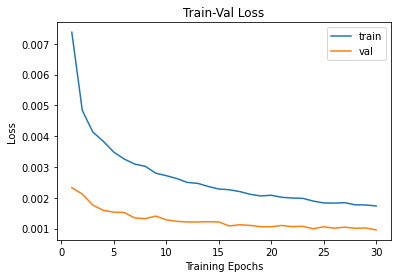

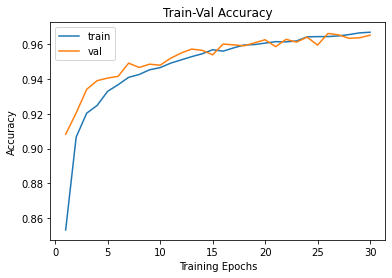

In [37]:
# 시각화 
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

## Student model 
- teacher의 지식을 transfer할 student modle 정의 

In [35]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800,800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800,10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [40]:
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

student = Student().to(device)
student.apply(initialize_weights);

## Knowledge distillation 
- teacher model의 soft label을 사용하여 student model을 knowledge distillation loss로 학습

In [46]:
teacher = Teacher().to(device)
teacher.load_state_dict(torch.load('teacher_weights.pt')) # teacher 

<All keys matched successfully>

In [47]:
student = Student().to(device)

In [49]:
opt = optim.Adam(student.parameters())

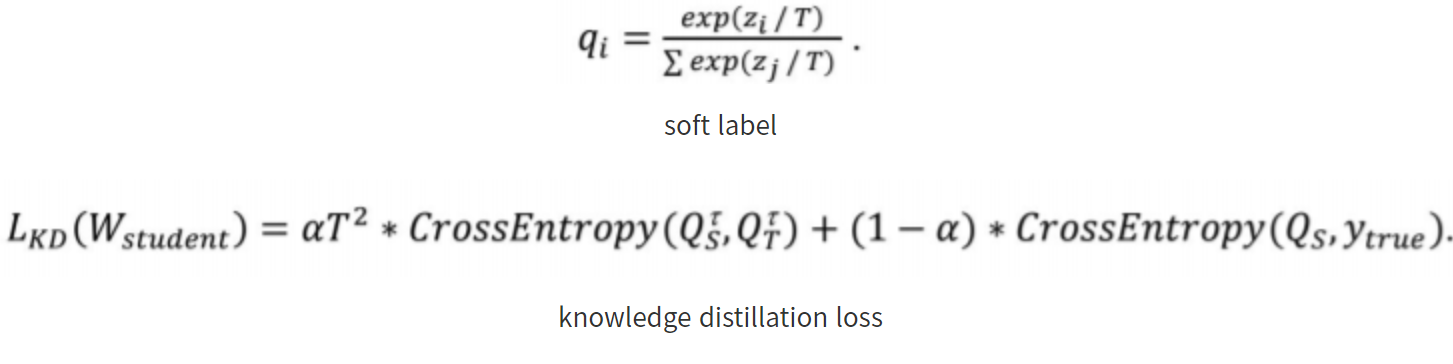

In [52]:
# knowledge distillation loss 
def distillation(y, labels, teacher_scores, T, alpha):
  # distillation loss + classification loss 
  # y -> student 
  # labels -> hard label 
  # teacher socers => soft label 
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)
loss_fucn = nn.CrossEntropyLoss()

In [53]:
def distill_loss_batch(output, target, teacher_output, loss_fn = distillation, opt=opt):
  loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
  metric_b = metric_batch(output, target)

  if opt is not None:
    opt.zero_grad()
    loss_b.backward()
    opt.step()
  return loss_b.item(), metric_b

In [54]:
# distillation 학습 

num_epochs= 100

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(train_loader.dataset)

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        output = student(xb)
        teacher_output = teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(student, loss_func, valid_loader)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/99, current lr= 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


train loss: 0.033648, val loss: 0.000833, accuracy: 97.29, time: 0.2085 min
----------
Epoch 1/99, current lr= 0.001
train loss: 0.028987, val loss: 0.000712, accuracy: 97.64, time: 0.4223 min
----------
Epoch 2/99, current lr= 0.001
train loss: 0.028478, val loss: 0.000616, accuracy: 97.87, time: 0.6291 min
----------
Epoch 3/99, current lr= 0.001
train loss: 0.028131, val loss: 0.000649, accuracy: 97.69, time: 0.8333 min
----------
Epoch 4/99, current lr= 0.001
train loss: 0.028022, val loss: 0.000608, accuracy: 97.84, time: 1.0440 min
----------
Epoch 5/99, current lr= 0.001
train loss: 0.027749, val loss: 0.000604, accuracy: 97.90, time: 1.2501 min
----------
Epoch 6/99, current lr= 0.001
train loss: 0.027675, val loss: 0.000599, accuracy: 97.88, time: 1.4569 min
----------
Epoch 7/99, current lr= 0.001
train loss: 0.027607, val loss: 0.000622, accuracy: 97.99, time: 1.6639 min
----------
Epoch 8/99, current lr= 0.001
train loss: 0.027487, val loss: 0.000548, accuracy: 97.90, time:

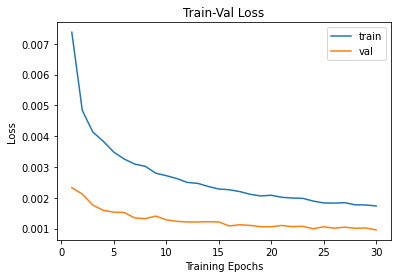

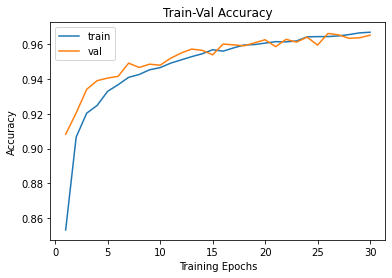

In [57]:
# 시각화 
# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()